## Task 1: Machine Translation using RNN, GRU, and LSTM

In [2]:
import numpy as np
import re
import tensorflow as tf
import unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from nltk.translate.bleu_score import sentence_bleu
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def load_data(filepath, max_samples=100000):
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = (line.strip() for line in f if '\t' in line)  
        pairs = [line.split('\t')[:2] for idx, line in zip(range(max_samples), lines)]
    return zip(*pairs)

en_texts, fr_texts = load_data('/kaggle/input/fra-eng/fra.txt')

In [5]:
en_texts[:5], fr_texts[:5]

(('Go.', 'Go.', 'Go.', 'Go.', 'Hi.'),
 ('Va !', 'Marche.', 'En route !', 'Bouge !', 'Salut !'))

In [6]:
def tokenize(sentences, num_words=10000, maxlen=20):
    tokenizer = Tokenizer(num_words=num_words, filters='', oov_token="<OOV>")
    tokenizer.fit_on_texts(sentences)
    
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, padding='post', maxlen=maxlen)
    return tokenizer, np.array(padded_sequences)

## tokenization w no limit gave OOM issues in my system
# def tokenize(sentences,maxlen=20):
#     tokenizer = Tokenizer(filters='', oov_token="<OOV>")
#     tokenizer.fit_on_texts(sentences)

#     num_words = len(tokenizer.word_index) + 1  # Get the vocabulary size
#     sequences = tokenizer.texts_to_sequences(sentences)
#     # maxlen = max(len(seq) for seq in sequences)  # Get the longest sentence length

#     padded_sequences = pad_sequences(sequences, padding='post', maxlen=maxlen)
#     return tokenizer, np.array(padded_sequences)
    
fr_tokenizer, fr_padded = tokenize(fr_texts)
fr_padded.shape

(100000, 20)

In [7]:
fr_tokenizer

In [8]:
en_tokenizer, en_padded = tokenize(en_texts)
en_padded.shape

(100000, 20)

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(en_padded, fr_padded, test_size=0.2, random_state=42)

In [10]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(80000, 20) (80000, 20)
(20000, 20) (20000, 20)


In [10]:
def build_rnn(vocab_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 128),
        tf.keras.layers.SimpleRNN(128, return_sequences=True),
        tf.keras.layers.Dense(vocab_size, activation='softmax')
    ])
    return model


def train_rnn(epochs=15, batch_size=32, patience=5):
    vocab_size = len(en_tokenizer.word_index) + 1
    model = build_rnn(vocab_size)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Early stopping if no improvement
    early_stopping = EarlyStopping(monitor='val_loss',patience=patience, restore_best_weights=True)

    hist = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2,callbacks=[early_stopping])

    return model, hist

In [ ]:
# Train RNN
rnn_model,rnn_hist = train_rnn()

Epoch 1/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.7826 - loss: 2.0226 - val_accuracy: 0.8178 - val_loss: 1.2099
Epoch 2/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8215 - loss: 1.1447 - val_accuracy: 0.8295 - val_loss: 1.0648
Epoch 3/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8331 - loss: 0.9862 - val_accuracy: 0.8345 - val_loss: 0.9854
Epoch 4/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8408 - loss: 0.8835 - val_accuracy: 0.8376 - val_loss: 0.9349
Epoch 5/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8463 - loss: 0.8096 - val_accuracy: 0.8407 - val_loss: 0.9012
Epoch 6/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8511 - loss: 0.7506 - val_accuracy: 0.8429 - val_loss: 0.8792
Epoch 7/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8559 - loss: 0.7009 - val_accuracy: 0.8441 - val_loss: 0.8621
Epoch 8/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8606 - loss: 0

In [ ]:
def plot_analysis(hist):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss Over Epochs')
    
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy Over Epochs')
    plt.show()

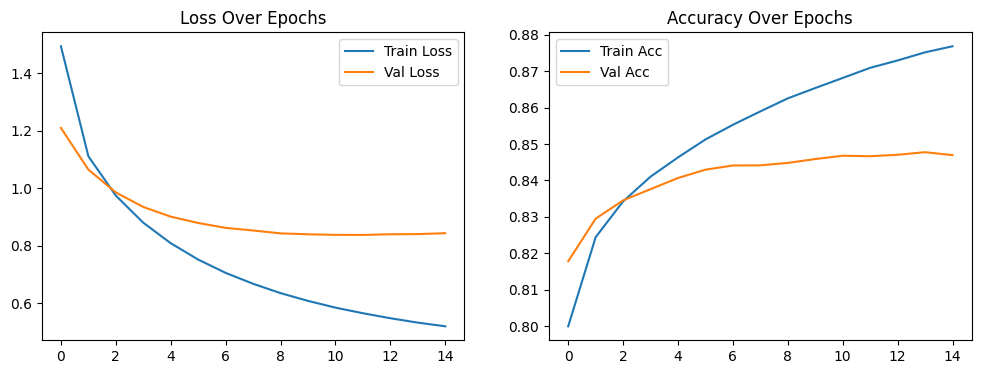

In [ ]:
plot_analysis(rnn_hist)

In [ ]:
# Compute BLEU score
def calc_bleu(y_true, y_pred, tokenizer):
    # Convert tokenized sequences to text
    references = [tokenizer.sequences_to_texts([seq])[0].split() for seq in y_true]
    candidates = [tokenizer.sequences_to_texts([seq])[0].split() for seq in y_pred]
    scores = [sentence_bleu([ref], cand) for ref, cand in zip(references, candidates)]
    return np.mean(scores)

In [ ]:
test_dat = tf.data.Dataset.from_tensor_slices(X_test[:1000]).batch(32)
y_pred_rnn = np.argmax(rnn_model.predict(test_dat), axis=-1)

bleu_score_rnn = calc_bleu(y_test[:len(y_pred_rnn)], y_pred_rnn, en_tokenizer)
print(f"BLEU Score: {bleu_score_rnn:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
BLEU Score: 0.7226


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [11]:

def build_gru(vocab_size, embedding_dim=128, units=128):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
        tf.keras.layers.GRU(units, return_sequences=True),
        tf.keras.layers.Dense(vocab_size, activation='softmax')
    ])
    return model


def train_gru(epochs=15, batch_size=16, patience=5):
    vocab_size = len(en_tokenizer.word_index) + 1
    model = build_gru(vocab_size)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Early stopping if no improvement
    early_stopping = EarlyStopping(monitor='val_loss',patience=patience, restore_best_weights=True)
    
    hist = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2,callbacks=[early_stopping])
    return model,hist

In [12]:
gru_model,gru_hist = train_gru()

Epoch 1/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 90s 22ms/step - accuracy: 0.7870 - loss: 1.8057 - val_accuracy: 0.8234 - val_loss: 1.1205
Epoch 2/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 87s 22ms/step - accuracy: 0.8283 - loss: 1.0412 - val_accuracy: 0.8350 - val_loss: 0.9661
Epoch 3/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 87s 22ms/step - accuracy: 0.8400 - loss: 0.8700 - val_accuracy: 0.8409 - val_loss: 0.8896
Epoch 4/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 87s 22ms/step - accuracy: 0.8485 - loss: 0.7636 - val_accuracy: 0.8439 - val_loss: 0.8454
Epoch 5/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 87s 22ms/step - accuracy: 0.8556 - loss: 0.6845 - val_accuracy: 0.8466 - val_loss: 0.8180
Epoch 6/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 87s 22ms/step - accuracy: 0.8611 - loss: 0.6271 - val_accuracy: 0.8472 - val_loss: 0.8034
Epoch 7/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 87s 22ms/step - accuracy: 0.8666 - loss: 0.5833 - val_accuracy: 0.8474 - val_loss: 0.7959
Epoch 8/15
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 87s 22ms/step - accuracy: 0.8705 -

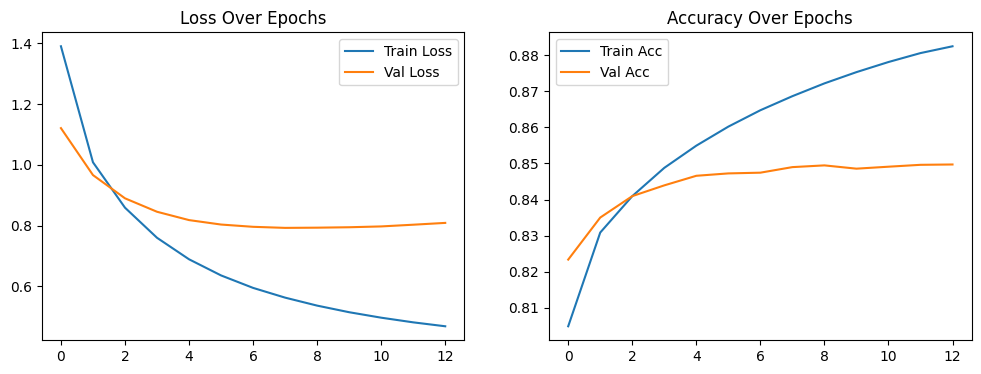

In [16]:
plot_analysis(gru_hist)

In [ ]:
test_dat = tf.data.Dataset.from_tensor_slices(X_test[:1000]).batch(32)
y_pred_gru = np.argmax(gru_model.predict(test_dat), axis=-1)

bleu_score_gru = calc_bleu(y_test[:len(y_pred_gru)], y_pred_gru, en_tokenizer)
print(f"BLEU Score: {bleu_score_gru:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
BLEU Score: 0.8054


In [18]:
def build_lstm(vocab_size, embedding_dim=128, units=256):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim),
        tf.keras.layers.LSTM(units, return_sequences=True),
        tf.keras.layers.Dense(vocab_size, activation='softmax')
    ])
    return model

def train_lstm(epochs=15, batch_size=32,patience=5):
    vocab_size = len(en_tokenizer.word_index) + 1
    model = build_lstm(vocab_size)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # Early stopping if no improvement
    early_stopping = EarlyStopping(monitor='val_loss',patience=patience, restore_best_weights=True)

    hist = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.2,callbacks=[early_stopping])

    return model,hist

In [ ]:
lstm_model,lstm_hist = train_lstm()

Epoch 1/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 83s 41ms/step - accuracy: 0.7766 - loss: 1.9828 - val_accuracy: 0.8148 - val_loss: 1.2129
Epoch 2/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.8195 - loss: 1.1388 - val_accuracy: 0.8294 - val_loss: 1.0224
Epoch 3/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.8349 - loss: 0.9299 - val_accuracy: 0.8373 - val_loss: 0.9185
Epoch 4/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.8439 - loss: 0.7982 - val_accuracy: 0.8422 - val_loss: 0.8561
Epoch 5/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.8523 - loss: 0.7000 - val_accuracy: 0.8456 - val_loss: 0.8173
Epoch 6/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.8605 - loss: 0.6229 - val_accuracy: 0.8477 - val_loss: 0.7974
Epoch 7/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.8669 - loss: 0.5676 - val_accuracy: 0.8496 - val_loss: 0.7861
Epoch 8/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.8724 -

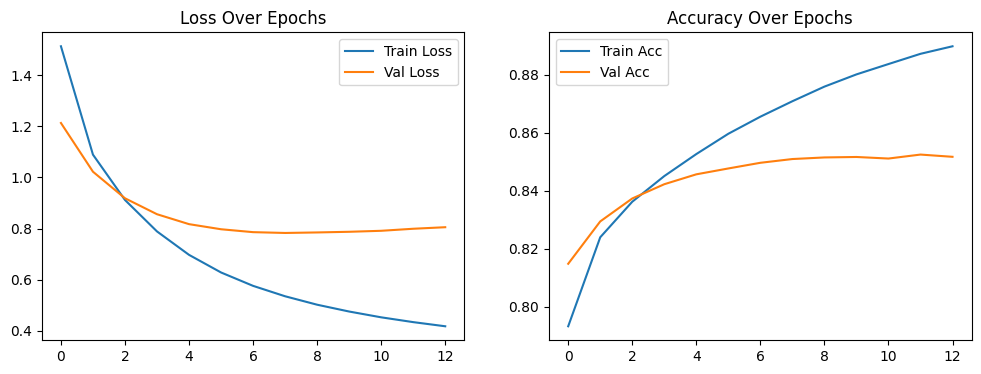

In [20]:
plot_analysis(lstm_hist)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np

test_dat = tf.data.Dataset.from_tensor_slices(X_test[:1000]).batch(32)
y_pred_lstm = np.argmax(lstm_model.predict(test_dat), axis=-1)

bleu_score_lstm = calc_bleu(y_test[:len(y_pred_lstm)], y_pred_lstm, en_tokenizer)
print(f"BLEU Score: {bleu_score_lstm:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
BLEU Score: 0.8063


#### Analysis

- RNN bleu score: 0.7226
- GRU bleu score: 0.8054
- LSTM bleu score: 0.8063

**Conclusion:** GRU and LSTM outperform RNN. The BLEU scores of GRU and LSTM are very close, indicating both architectures are almost equally effective,

## Task 2: Stock Market Forecasting using RNN, GRU, and LSTM

In [22]:
!pip install yfinance

In [16]:
# import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
def load_stock_data(ticker):
    start = datetime.datetime(1998, 12, 31)
    end = datetime.datetime(2024, 2, 20)
    df = web.DataReader("AAPL","stooq", start, end)
    return df

In [18]:
df = load_stock_data('AAPL')

In [19]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2024-02-20,181.334,181.972,179.548,181.104,5.380054e+07
2024-02-16,182.960,184.387,181.209,181.853,4.987761e+07
2024-02-15,183.089,184.027,180.895,183.399,6.559909e+07
2024-02-14,184.855,185.065,181.982,183.688,5.476793e+07
2024-02-13,185.304,185.743,183.052,184.575,5.667172e+07


In [20]:
df = df[["Close"]]
df.head()

,Close
Date,
2024-02-20,181.104
2024-02-16,181.853
2024-02-15,183.399
2024-02-14,183.688
2024-02-13,184.575


In [21]:
def preprocess(data, seq_len=40):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scl_close = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(seq_len, len(scl_close)):
        X.append(scl_close[i-seq_len:i, 0])
        y.append(scl_close[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

In [22]:
X, y, scaler = preprocess(df.values)

X.T, y, scaler

(array([[[9.17540778e-01, 9.21339644e-01, 9.29180827e-01, ...,
          2.75171769e-04, 3.02864434e-04, 3.19703198e-04],
         [9.21339644e-01, 9.29180827e-01, 9.30646611e-01, ...,
          3.02864434e-04, 3.19703198e-04, 2.87390017e-04],
         [9.29180827e-01, 9.30646611e-01, 9.35145401e-01, ...,
          3.19703198e-04, 2.87390017e-04, 3.28614556e-04],
         ...,
         [9.74427396e-01, 9.77206806e-01, 9.82669261e-01, ...,
          7.17148735e-04, 7.17148735e-04, 5.93125156e-04],
         [9.77206806e-01, 9.82669261e-01, 9.83419904e-01, ...,
          7.17148735e-04, 5.93125156e-04, 6.52821616e-04],
         [9.82669261e-01, 9.83419904e-01, 9.94086145e-01, ...,
          5.93125156e-04, 6.52821616e-04, 5.73172236e-04]]]),
 array([9.83419904e-01, 9.94086145e-01, 9.88775848e-01, ...,
        6.52821616e-04, 5.73172236e-04, 5.61902437e-04]),
 MinMaxScaler())

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [37]:
def train_model(model, X_train, y_train):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    return model, history

def run_model(model_name,  X_train, y_train):
    if model_name == "RNN":
        model = build_rnn((X_train.shape[1], 1))
    elif model_name == "GRU":
        model = build_gru((X_train.shape[1], 1))
    elif model_name == "LSTM":
        model = build_lstm((X_train.shape[1], 1))
    model, history = train_model(model, X_train, y_train)
    return model, history
    # evaluate_model(model, X_test, y_test, scaler, model_name)

In [38]:
def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(128, return_sequences=False, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [39]:
rnn_model,rnn_history = run_model('RNN', X_train, y_train)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0324 - val_loss: 1.3093e-06
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6883e-04 - val_loss: 5.6820e-06
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3525e-04 - val_loss: 1.9866e-06
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9420e-04 - val_loss: 1.2958e-05
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4554e-04 - val_loss: 4.8812e-07
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6150e-04 - val_loss: 6.0977e-07
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8487e-04 - val_loss: 6.8521e-06
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5080e-04 - val_loss: 6.3503e-06
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0490e-04 - val_loss: 5.9638e-06
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6294e-04 - val_loss: 5.1873e-07


In [40]:
def plot_loss(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

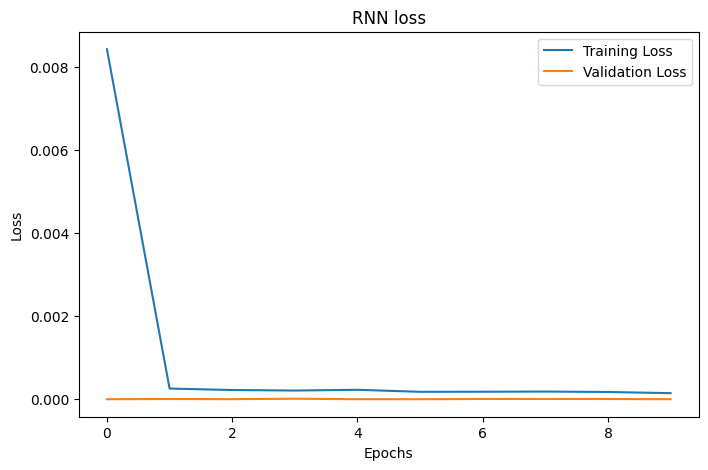

In [41]:
plot_loss(rnn_history, "RNN loss")

In [42]:
def evaluate_model(model, X_test, y_test, scaler, model_name):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
    print(f'{model_name} RMSE: {rmse}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual, label='Actual Prices')
    plt.plot(predictions, label='Predicted Prices')
    plt.title(f'{model_name} - Actual vs. Predicted Prices')
    plt.legend()
    plt.show()
    

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
RNN RMSE: 0.07841854210313602


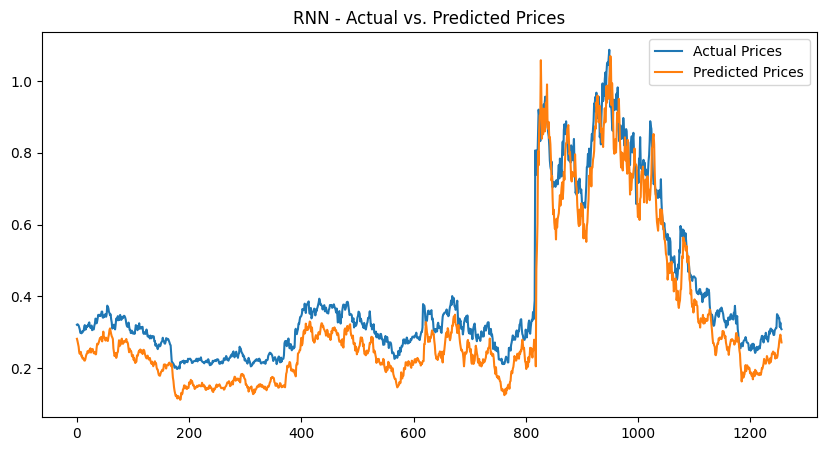

In [44]:
evaluate_model(rnn_model, X_test, y_test, scaler,'RNN')

In [18]:
def build_gru(input_shape):
    model = Sequential([
        GRU(128, return_sequences=False, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [20]:
gru_model,gru_history = run_model('GRU', X_train, y_train)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0222 - val_loss: 6.4435e-06
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0842e-04 - val_loss: 1.4562e-06
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.8023e-05 - val_loss: 5.0906e-07
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.7339e-05 - val_loss: 7.9522e-06
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.2754e-05 - val_loss: 1.4442e-05
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0296e-04 - val_loss: 3.1686e-06
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.7963e-05 - val_loss: 4.3690e-07
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3845e-05 - val_loss: 2.1122e-06
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5725e-05 - val_loss: 2.3721e-07
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3487e-05 - val_loss: 2.3862e-06
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.

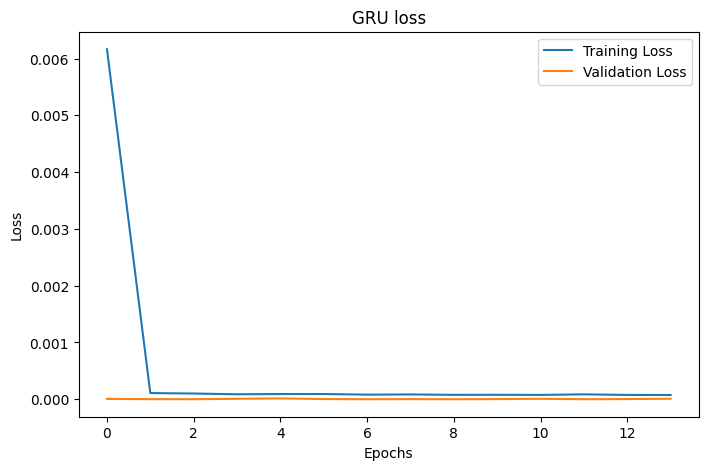

In [21]:
plot_loss(gru_history, "GRU loss")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
GRU RMSE: 0.060913146748002175


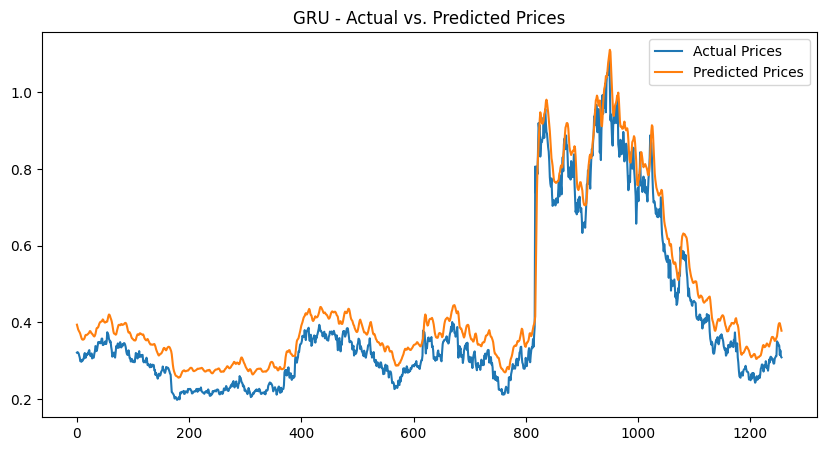

In [22]:
evaluate_model(gru_model, X_test, y_test, scaler,'GRU')

In [46]:
def build_lstm(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [47]:
lstm_model,lstm_history = run_model('LSTM', X_train, y_train)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0125 - val_loss: 1.3671e-05
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8676e-04 - val_loss: 9.2000e-06
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7391e-04 - val_loss: 2.2632e-06
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0146e-04 - val_loss: 6.6463e-06
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7561e-04 - val_loss: 1.2361e-05
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8062e-04 - val_loss: 3.1422e-06
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5806e-04 - val_loss: 3.3839e-07
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8901e-04 - val_loss: 6.9031e-07
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3647e-04 - val_loss: 2.4875e-06
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3973e-04 - val_loss: 8.5575e-07
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1818e-04 -

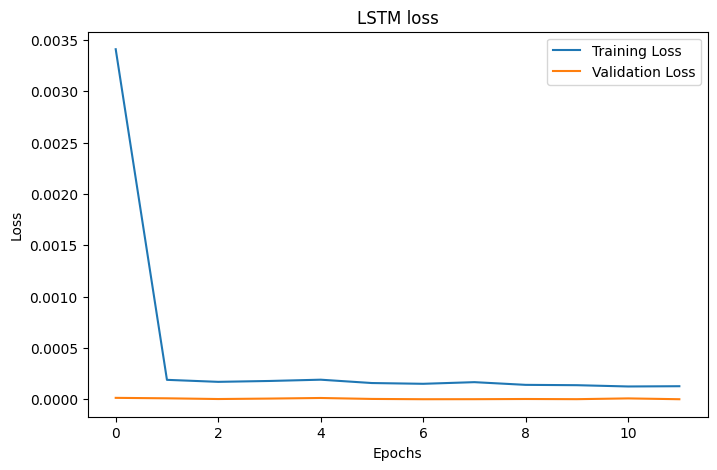

In [48]:
plot_loss(lstm_history, "LSTM loss")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM RMSE: 0.04191454309669966


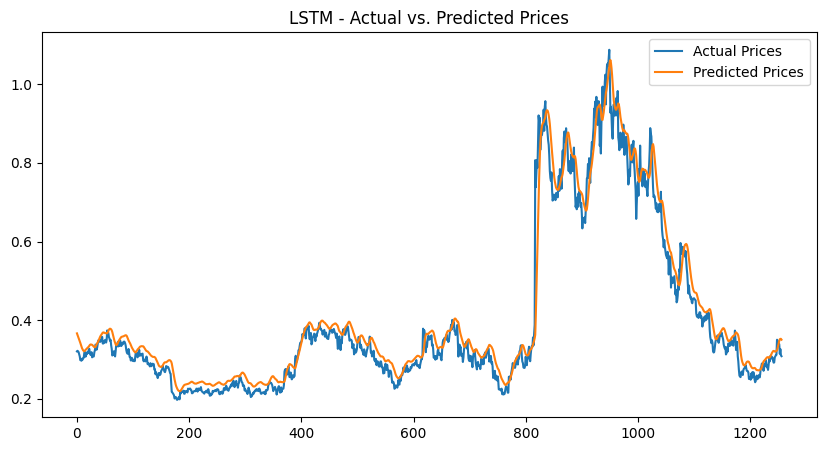

In [49]:
evaluate_model(lstm_model, X_test, y_test, scaler,'LSTM')

#### Analysis

- RNN RMSE: 0.07841
- GRU RMSE: 0.06091
- LSTM RMSE: 0.04191

**Conclusion:** LSTM performs best as it handles long-term dependencies well using its gating mechanisms